<a href="https://colab.research.google.com/github/juelha/IANNWTF/blob/sabine/hw09_Sabine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import os
#import glob
#import imageio
#import matplotlib.pyplot as plt
import numpy as np
#import PIL
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
import matplotlib.pyplot as plt


#from IPython import display

In [3]:
# Dataset 

import urllib
categories = [line.rstrip(b'\n') for line in urllib.request.urlopen('https://raw.githubusercontent.com/googlecreativelab/quickdraw-dataset/master/categories.txt')]
print(categories[:10])
category = 'candle'

# Creates a folder to download the original drawings into.
# We chose to use the numpy format : 1x784 pixel vectors, with values going from 0 (white) to 255 (black). We reshape them later to 28x28 grids and normalize the pixel intensity to [-1, 1]

if not os.path.isdir('npy_files'):
    os.mkdir('npy_files')
    
url = f'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/{category}.npy'  
urllib.request.urlretrieve(url, f'npy_files/{category}.npy')

images = np.load(f'npy_files/{category}.npy')
print(f'{len(images)} images to train on')
candle = images[:1].reshape(28,28)
print(candle)

# You can limit the amount of images you use for training by setting :
train_images = images[:10000]
# You should also define a samller subset of the images for testing..
test_images = images[10000:15000]

[b'aircraft carrier', b'airplane', b'alarm clock', b'ambulance', b'angel', b'animal migration', b'ant', b'anvil', b'apple', b'arm']
141545 images to train on
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  49  87   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  11 169 254 255  57
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  15 196 250 120 225 192
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 126 251 103 129  98 255
   71   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 144 232 215 255  62 234
  150   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 151 234 255 255 143 178
  206   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0  

In [4]:
#not working
#trying to make an image out of the numpy vectors
from PIL import Image
w,h=28,28
t=(h,w,3)
A=np.zeros(t,dtype=np.uint8)
for i in range(h):
    for j in range(w):
        A[i,j]=[i%256,j%256,(i+j)%256]
i=Image.fromarray(A,"RGB")
i.show()

In [5]:
# Preprocessing

ds_train = tf.data.Dataset.from_tensor_slices(train_images)
ds_test = tf.data.Dataset.from_tensor_slices(test_images)

batch_size = 32

def preprocessing(tensor):
  tensor = tensor.map(lambda tensor: (tf.reshape(tensor, (28,28)))) # reshape
  tensor = tensor.map(lambda tensor: (tf.expand_dims(tensor, -1))) # make 3D tensor in case we add more filters
  tensor = tensor.map(lambda tensor: (tensor / 255)) # normalise TO DO: try z score normalisation? 
  #tensor = tensor.map(lambda tensor: (tensor, 1)) # add target, image is real = 1
  # the normal shuffle, batch, prefetch
  tensor = tensor.shuffle(1000)
  tensor = tensor.batch(batch_size)
  tensor = tensor.prefetch(20)
  return tensor

train_dataset = ds_train.apply(preprocessing)
test_dataset = ds_test.apply(preprocessing)

check = train_dataset.take(1)
print(check)


<TakeDataset shapes: (None, 28, 28, 1), types: tf.float32>


In [30]:
# Model

class Discriminator(tf.keras.Model):
  def __init__(self): 
    super(Discriminator, self).__init__()
    self.conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(2,2), padding='same', activation='relu', input_shape=(28, 28)) # TO DO: check using leaky ReLU
    self.batchnorm1 = tf.keras.layers.BatchNormalization()
    self.dropout1 = tf.keras.layers.Dropout(.2)
    
    self.conv2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(2,2), padding='same', activation='relu') #downsample
    self.batchnorm2 = tf.keras.layers.BatchNormalization()
    self.dropout2 = tf.keras.layers.Dropout(.2)
    
    self.conv3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(2,2), padding='same', activation='relu')
    self.batchnorm3 = tf.keras.layers.BatchNormalization()
    self.dropout3 = tf.keras.layers.Dropout(.2)

    self.conv4 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(2,2), padding='same', activation='relu')
    self.batchnorm4 = tf.keras.layers.BatchNormalization()
    self.dropout4 = tf.keras.layers.Dropout(.2)

    self.conv5 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(2,2), padding='same', activation='relu')
    self.batchnorm5 = tf.keras.layers.BatchNormalization()
    self.dropout5 = tf.keras.layers.Dropout(.2)

    self.globalmax = tf.keras.layers.GlobalMaxPooling2D()
    self.dense = tf.keras.layers.Dense(1, activation='sigmoid')    
   

  def call(self, x, training):  # TO DO: training = training? Where exactly to implement
    x = self.conv1(x)
    x = self.batchnorm1(x)
    x = self.dropout1(x)

    x = self.conv2(x)
    x = self.batchnorm2(x)
    x = self.dropout2(x)

    x = self.conv3(x)
    x = self.batchnorm3(x)
    x = self.dropout3(x)

    x = self.conv4(x)
    x = self.batchnorm4(x)
    x = self.dropout4(x)

    x = self.conv5(x)
    x = self.batchnorm5(x)
    x = self.dropout5(x)

    x = self.globalmax(x)
    x = self.dense(x)

    return x 

class Generator(tf.keras.Model): 
  def __init__(self): 
    super(Generator, self).__init__()
    nodes = 128*5*5 # 5x5 feature map of 128 copies
    self.dense1 = tf.keras.layers.Dense(nodes, activation='relu')
    self.reshape = tf.keras.layers.Reshape((5,5,128))
    self.convtrans1 = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(2,2), padding='same', activation='relu') #upsample to 10x10
    self.convtrans2 = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(2,2), padding='same', activation='relu') #upsample to 20x20
    self.convtrans3 = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(2,2), padding='same', activation='relu') #upsample to 40x40
    self.convtrans4 = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(2,2), padding='same', activation='relu') #upsample to 80x80
    self.conv1 = tf.keras.layers.Conv2D(filters=1, kernel_size=(5,5), strides=(2,2), padding='same', activation='tanh')

  def call(self, x):  # TO DO: training = training? Where exactly to implement
    x = self.dense1(x)
    x = self.reshape(x)
    x = self.convtrans1(x)
    x = self.convtrans2(x)
    x = self.convtrans3(x)
    x = self.convtrans4(x)
    x = self.conv1(x)

    return x 




image_shape = ((1,100))
dummy = tf.ones(image_shape)

model = Generator()
fake_image=model(dummy)
model.summary()

model = Discriminator()
model(fake_image)
model.summary()



Model: "generator_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             multiple                  323200    
                                                                 
 reshape_1 (Reshape)         multiple                  0         
                                                                 
 conv2d_transpose_4 (Conv2DT  multiple                 262272    
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  multiple                 262272    
 ranspose)                                                       
                                                                 
 conv2d_transpose_6 (Conv2DT  multiple                 262272    
 ranspose)                                                       
                                                       

In [7]:
# Training

def train_step(D, G, real_image, D_optimizer, G_optimizer):
  """Applys optimizer to all trainable variables of this model to
  minimize the loss (loss_function) between the target output and the
  predicted ouptut.
  :param input: tf.Tensor input to the model
  :param target: target output with repect to the input
  :return: the loss and the accuracy of the models prediction
   """
  #in each training step, the generator is fed with random noise 9 and creates images from it. 
  latent_point = tf.random.normal([real_image.shape[-1], 100]) 

  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as G_tape, tf.GradientTape() as D_tape:
            
    fake_image = G(latent_point)
    real_prediction = D(real_image)
    fake_prediction = D(fake_image)

    D_loss = -tf.math.reduce_mean( tf.math.log(real_prediction) + tf.math.log(1-fake_prediction) ) # tf minimising term, making negative. 0 optimal value for good discrim. bad dis would lead to very negative result, loss = very high = bad, best = close to 0 but poisitive
    G_loss = tf.math.reduce_mean( tf.math.log(1-fake_prediction) ) # better gen, closer to 0. more negative loss = better. 

    D_gradients = D_tape.gradient(D_loss, D.trainable_variables)
    D_optimizer.apply_gradients(zip(D_gradients, D.trainable_variables))

    G_gradients = G_tape.gradient(G_loss, G.trainable_variables)
    G_optimizer.apply_gradients(zip(G_gradients, G.trainable_variables))
    
def test(D, G, test_data, batch_size):
  """Calculate the mean loss and accuracy of the model over all elements
  of test_data.
  :param test_data: model is evaulated for test_data
  :param: loss_function: chosen cost function
  :return: mean loss and mean accuracy for all datapoints
  """

  D_accuracy_aggregator_real = []
  D_accuracy_aggregator_fake = []
  D_loss_aggregator = []
  G_loss_aggregator = []
  
  for real_images in test_data: # batch of real_images

    latent_points = tf.random.normal([real_images.shape[-1], 100])  # batch of fake_images made from sampling the latent space

    fake_images = G(latent_points)
    real_prediction = D(real_images)
    fake_prediction = D(fake_images)

    D_loss = -tf.math.reduce_mean( tf.math.log(real_prediction) + tf.math.log(1-fake_prediction) ) # tf minimising term, making negative. 0 optimal value for good discrim. bad dis would lead to very negative result, loss = very high = bad. loss = very close to 0 but positive
    G_loss = tf.math.reduce_mean( tf.math.log(1-fake_prediction) ) # better gen, closer to 0. more negative loss = better.  

    D_accuracy_real = tf.math.round(real_prediction) == 1 
    D_accuracy_fake = tf.math.round(fake_prediction) == 0

    D_loss_aggregator.append(D_loss.numpy())
    G_loss_aggregator.append(G_loss.numpy())
    D_accuracy_aggregator_real.append(np.mean(D_accuracy_real))
    D_accuracy_aggregator_fake.append(np.mean(D_accuracy_fake))

  D_loss = tf.reduce_mean(D_loss_aggregator)
  G_loss = tf.reduce_mean(G_loss_aggregator)
  test_accuracy_real = tf.reduce_mean(D_accuracy_aggregator_real)
  test_accuracy_fake = tf.reduce_mean(D_accuracy_aggregator_fake)

  return D_loss, G_loss, test_accuracy_real, test_accuracy_fake


In [8]:
latent_points = tf.random.normal([batch_size, 100])
Gen = Generator()
fake = Gen(latent_points)

Gen.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  323200    
                                                                 
 reshape (Reshape)           multiple                  0         
                                                                 
 conv2d_transpose (Conv2DTra  multiple                 262272    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  multiple                 262272    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  multiple                 262272    
 ranspose)                                                       
                                                         

Epoch: 0 starting with accuracy 0.0
Discriminator Test Losses: 0.2109711766242981, Generator Test Losses: -0.14252282679080963


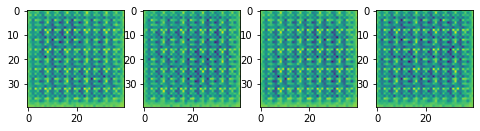

Epoch: 1 starting with accuracy 1.0
Discriminator Test Losses: 0.005262427497655153, Generator Test Losses: -0.0029679073486477137


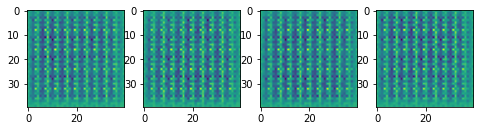

Epoch: 2 starting with accuracy 1.0
Discriminator Test Losses: 0.0014659948647022247, Generator Test Losses: -0.0008038015803322196


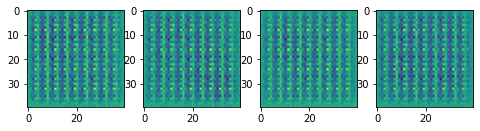

Epoch: 3 starting with accuracy 1.0
Discriminator Test Losses: 0.0006621460779570043, Generator Test Losses: -0.00035848101833835244


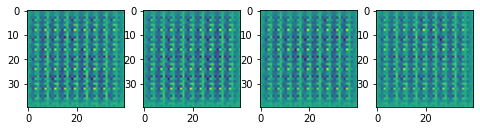

Epoch: 4 starting with accuracy 1.0
Discriminator Test Losses: 0.0003653234743978828, Generator Test Losses: -0.0001960596564458683


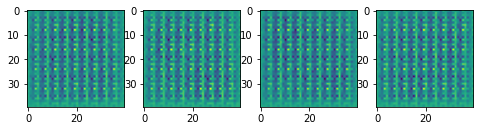

Epoch: 5 starting with accuracy 1.0
Discriminator Test Losses: 0.00022471458942163736, Generator Test Losses: -0.00012009007332380861


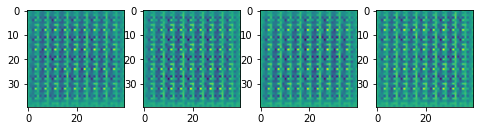

Epoch: 6 starting with accuracy 1.0
Discriminator Test Losses: 0.00014811950677540153, Generator Test Losses: -7.8856639447622e-05


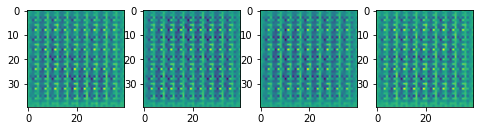

Epoch: 7 starting with accuracy 1.0
Discriminator Test Losses: 0.0001025609890348278, Generator Test Losses: -5.43871101399418e-05


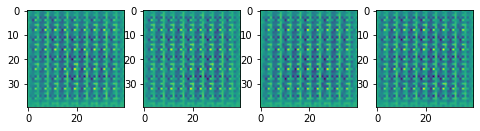

Epoch: 8 starting with accuracy 1.0
Discriminator Test Losses: 7.335899135796353e-05, Generator Test Losses: -3.8857291656313464e-05


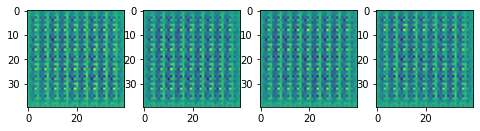

Epoch: 9 starting with accuracy 1.0
Discriminator Test Losses: 5.396008418756537e-05, Generator Test Losses: -2.8518381441244856e-05


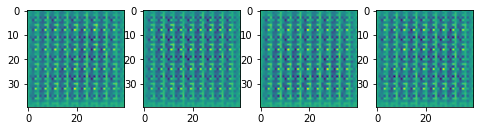

Epoch: 10 starting with accuracy 1.0
Discriminator Test Losses: 4.0447925130138174e-05, Generator Test Losses: -2.1314013793016784e-05


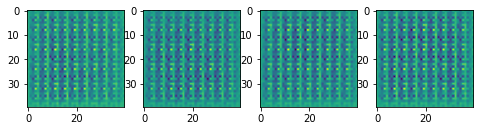

Epoch: 11 starting with accuracy 1.0
Discriminator Test Losses: 3.0755716579733416e-05, Generator Test Losses: -1.617311136214994e-05


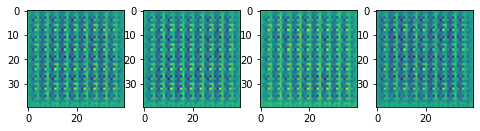

Epoch: 12 starting with accuracy 1.0
Discriminator Test Losses: 2.3645483452128246e-05, Generator Test Losses: -1.2427454748831224e-05


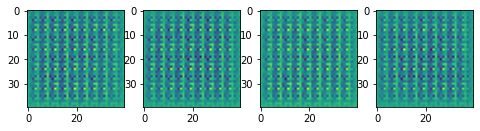

Epoch: 13 starting with accuracy 1.0
Discriminator Test Losses: 1.8405289665679447e-05, Generator Test Losses: -9.645369573263451e-06


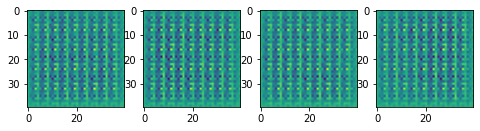

Epoch: 14 starting with accuracy 1.0
Discriminator Test Losses: 1.4462119906966109e-05, Generator Test Losses: -7.560706308140652e-06


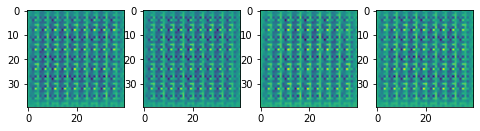

Epoch: 15 starting with accuracy 1.0
Discriminator Test Losses: 1.1468924640212208e-05, Generator Test Losses: -5.983261416986352e-06


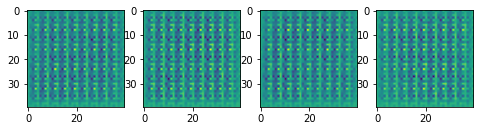

Epoch: 16 starting with accuracy 1.0
Discriminator Test Losses: 9.118368325289339e-06, Generator Test Losses: -4.7577527766407e-06


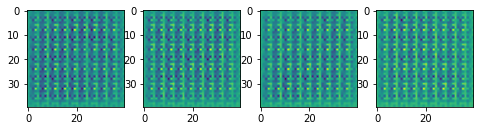

Epoch: 17 starting with accuracy 1.0
Discriminator Test Losses: 7.306376119231572e-06, Generator Test Losses: -3.8078710531408433e-06


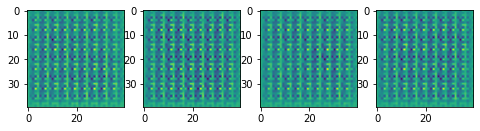

Epoch: 18 starting with accuracy 1.0
Discriminator Test Losses: 5.864724244020181e-06, Generator Test Losses: -3.0497121770167723e-06


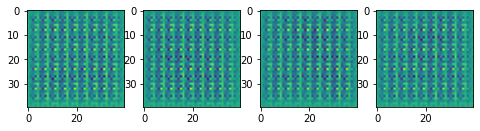

Epoch: 19 starting with accuracy 1.0
Discriminator Test Losses: 4.7449107114516664e-06, Generator Test Losses: -2.4707485408725915e-06


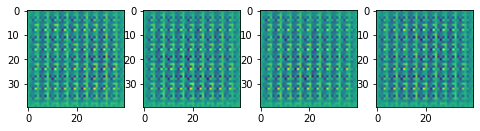

Epoch: 20 starting with accuracy 1.0
Discriminator Test Losses: 3.868002750095911e-06, Generator Test Losses: -2.014411165873753e-06


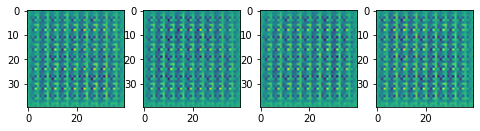

Epoch: 21 starting with accuracy 1.0
Discriminator Test Losses: 3.1198323995340616e-06, Generator Test Losses: -1.6104656879178947e-06


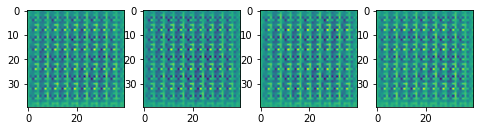

Epoch: 22 starting with accuracy 1.0
Discriminator Test Losses: 2.5432639176869998e-06, Generator Test Losses: -1.3113030945532955e-06


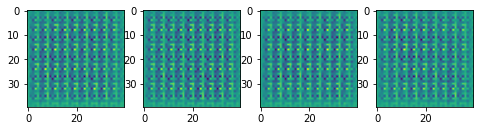

Epoch: 23 starting with accuracy 1.0
Discriminator Test Losses: 2.08011601898761e-06, Generator Test Losses: -1.0728841743912199e-06


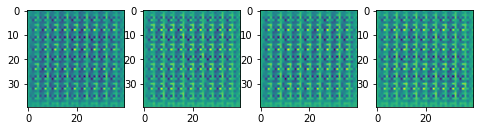

Epoch: 24 starting with accuracy 1.0
Discriminator Test Losses: 1.720992372611363e-06, Generator Test Losses: -8.940700695347914e-07


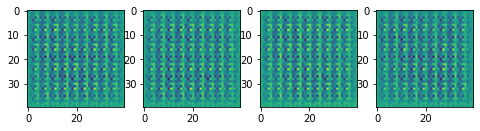

Epoch: 25 starting with accuracy 1.0


In [ ]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 30
learning_rate = 0.00001

# Initialize the model.
G = Generator()
D = Discriminator()

# Initialize the optimizer.
D_optimizer, G_optimizer = tf.keras.optimizers.Adam(learning_rate), tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
D_losses_train = []
G_losses_train = []
train_accuracies = []

D_losses_test = []
G_losses_test = []
test_accuracies = []

#testing once before we begin
D_loss, G_loss, test_accuracy_real, test_accuracy_fake = test(D, G, test_dataset, batch_size)
D_losses_test.append(D_loss)
G_losses_test.append(G_loss)
test_accuracies += [test_accuracy_real, test_accuracy_fake]

#check how model performs on train data once before we begin
D_loss, G_loss, test_accuracy_real, test_accuracy_fake = test(D, G, train_dataset, batch_size)
D_losses_train.append(D_loss)
G_losses_train.append(G_loss)
train_accuracies += [test_accuracy_real, test_accuracy_fake]


# train for num_epochs epochs.
for epoch in range(num_epochs):
    print(f'Epoch: {str(epoch)} starting with accuracy {test_accuracies[-1]}')
    
    #training (and checking in with training)
    epoch_loss_agg = []
    for real_images in train_dataset:
        train_step(D, G, real_images, D_optimizer, G_optimizer) 
  
    #testing, so we can track accuracy and test loss
    D_loss, G_loss, test_accuracy_real, test_accuracy_fake = test(D, G, test_dataset, batch_size)
    D_losses_test.append(D_loss)
    G_losses_test.append(G_loss)
    test_accuracies += [test_accuracy_real, test_accuracy_fake]
    print(f'Discriminator Test Losses: {D_losses_test[-1].numpy()}, Generator Test Losses: {G_losses_test[-1].numpy()}')

    latent_points = tf.random.normal([4, 100])
    fake_images = G(latent_points).numpy()


    w = 10
    h = 10
    fig = plt.figure(figsize=(8, 8))
    columns = 4
    rows = 1
    for i in range(1, columns*rows+1):
      img = np.squeeze(fake_images[i-1])
      fig.add_subplot(rows, columns, i)
      plt.imshow(img)
    plt.show()


    